## Error Measures

We have already gotten into the innards of a popular machine learning algorithm, KNN, and we have shown how to evaluate its performance. What we have not shown is what that evaluation of performance means.

In evaluating a ML algorithm we compare the predicted results to the actual results, but that comparison is not prespecified. We have thusfar been using accuracy (which is useful for classification). But we can use many different forms. Let's start off by cleaning the data and doing a prediction on a new class: was political.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

breast_cancer_data = load_breast_cancer()

# we make our test set
X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data['data'], breast_cancer_data['target'], test_size=0.2, random_state=1)

# and we make our validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [2]:
print X_train.shape, X_val.shape, X_test.shape

(364, 30) (91, 30) (114, 30)


In [3]:
from sklearn.neighbors import KNeighborsClassifier

cls = KNeighborsClassifier(n_neighbors=3, weights='uniform')

cls.fit(X_train, y_train)

print cls.score(X_train, y_train)
print cls.score(X_val, y_val)

0.950549450549
0.934065934066


Pretty great accuracy right? We are correct in our predictions 93.4% of the time. Of course we will need to validate on our test set in order to get a tight bound (though we did only test one hypothesis here with our validation set).

The problem here is that accuracy only tells one side of the story. 

Here is a question for you: what if 93% of the data was benign cancer?

In order to investigate the rest of the story, we will need to look at a confusion matrix, so let's make one below:

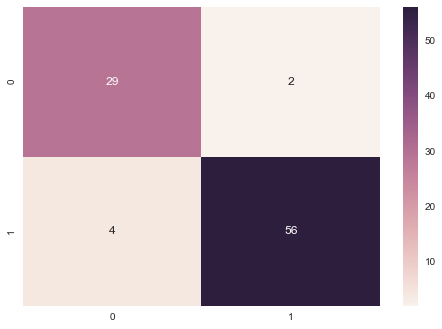

In [4]:
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(cls.predict(X_val), y_val), annot=True)

Okay, what are we looking at here? So notice that the matrix has four entries: two rows and two columns, where the rows and the columns have the same labels. The columns represent the true class of the data point. The rows represent the predicted value.

So anything along the diagonal of the matrix was correctly predicted and anything off the diagonal was incorrectly predicted. And this is where we get to see something terrible about the predictions that we have made thusfar. While we get most of the 'not political' billionaires correct, we barely get any of the political billionaires correct!

One of the other tools that is extremely useful to determine the true accuracy of your algorithm is the classification report:

In [5]:
from sklearn.metrics import classification_report

print classification_report(cls.predict(X_val), y_val)

             precision    recall  f1-score   support

          0       0.88      0.94      0.91        31
          1       0.97      0.93      0.95        60

avg / total       0.94      0.93      0.93        91



Here we get the second best way to evaluate the performance of a classification model: precision and recall. 

Don't be too scared here as the terms are simply ways to summarize the above confusion matrix. Each class has its own precision, recall, f1 and support. 

* Precision: precision is a measure of how accurate your predictions are of the particular class. High precision means that when you predict a data point is this class, you should be pretty sure it is. Technically it is the number of correctly predicted instances of that class over total instances predicted of that class.
* Recall: recall is a measure of how well you can find members of this class in the dataset. High recall means that you will be confident that you can identify a member of this class if you see it. Technically it is the number of correctly predicted instances of that class over total instances of that class.
* F1 Score: this is simply an average of precision and recall. It is generally better to present both precision and recall rather than just F1.
* Support: This is simple number of data points in this class.

What you will look for is large imbalances in the class or in the percision to recall. Fortunately we don't have large ones in our dataset above.

## Other topics

We could dwell on this topic for a full class, but it is good to mention some other very important techniques before we proceed. 

#### ROC/Precision Recall Curve

One of the ways that we can further see how well our model does is change the threshold at which we predict certain classes. Previously we would claim a specific class only if we thought the probability it was that class was over 50%, but for very important decisions (cancer screened perhaps), you would want to be alerted when the chance was only 10%. The Precision Recall Curve (and ROC) is a way to visualize performance over these different thresholds.

#### Class Imbalance

Today we have seen that our algorithm does much better at predicting the more represented class. This is a common problem and there are many solutions to this problem (including sub-sampling and class reweighting) but we will not have the time to go over them during this class.

## Learning Objectives

Today we are going to learn about different error measures, specifically those for qualitative outputs. You need to be very careful with choosing an error measure for a specific dataset, and today we will learn why

## Comprehension Questions

1.	Why is accuracy a bad measure of how well an algorithm performs?
2.	Is MSE a good measure? 
3.	What measure would you use for self driving cars?
4.	How would you describe precision and recall to a non-technical person?
5.	What is a dataset where you would only care about recall? What about precision? 
